<a href="https://colab.research.google.com/github/graceebc9/Arch_Class/blob/main/train_svi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train DCNN on facades for architecture Classification 


In [1]:
!pip install wandb
import wandb
!pip install pytorch_lightning 
import pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=01ba01e633a6550205e548090cacb07615788b90f4065143e4f4e78dae9a8815
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 35.3 MB/s

In [2]:


#Store the PyTorch Lightning Data Modules and Model Classes 

import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule ,Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import wandb
from torch.utils.data import Dataset, DataLoader
from torchvision import  utils
import torchvision.transforms as T
import torchvision
import torchvision.models as models
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

torch.manual_seed(17)

from torchmetrics.classification import Accuracy, Recall
from torchmetrics import Precision, JaccardIndex
from torch.nn import  NLLLoss


import numpy as np
import glob
import random

import sys
from PIL import Image
import random
import os
import glob


from pytorch_lightning.callbacks import ModelCheckpoint

import torchvision.models as models
import torch
import pandas as pd
import wandb 
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
base_dir = '/content/gdrive/MyDrive'

import sys
sys.path.insert(0, base_dir + '/HurricanDamage_Data')

from src import    ImagePredictionLogger, ImagePredictionLogger_table, extract_predictions

In [6]:


import os
from typing import Tuple
import os
from typing import Optional
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import torchvision.transforms as T

import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torchvision.models as models

import numpy as np
from typing import Optional

import os
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler



In [7]:


class StreetViewData(Dataset):
    def __init__(self, root_dir: str, transform: Optional[transforms.Compose] = None):
        self.root_dir = root_dir
        self.transform = transform

        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = []

        print(self.classes)
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for i in range(3700):
                
                sample_path = os.path.join(class_dir, f"gsv_{i}.jpg")
                if not os.path.exists(sample_path):
                    None
                else:
                    self.samples.append((sample_path, self.class_to_idx[class_name]))
               

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        sample_path, label = self.samples[index]

        with open(sample_path, "rb") as f:
            sample = Image.open(f).convert("RGB")

        if self.transform:
            sample = self.transform(sample)

        return sample, label

class MyDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, transform=None, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = T.Compose([ T.CenterCrop(size=150), T.Resize( size = (224, 224) ), T.ToTensor() ])       
        self.dataset = StreetViewData(data_dir, self.transform)

       
        

    def setup(self, stage=None): 
        # split into train, val, and test sets
        num_samples = len(self.dataset)
        indices = list(range(num_samples))
        split_train = int(np.floor(0.7 * num_samples))
        split_val = int(np.floor(0.15 * num_samples))
        np.random.shuffle(indices)
        train_indices, val_indices, test_indices = indices[:split_train], indices[split_train:split_train+split_val], indices[split_train+split_val:]
        print('Num train:{} Num val:{} Num test:{}'.format(len(train_indices), len(val_indices), len(test_indices)) )
        print('total num: {}  total sum: {}'.format(num_samples, (len(train_indices)+ len(val_indices)+ len(test_indices))))
        # define samplers
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        test_sampler = SubsetRandomSampler(test_indices)
        # set up data loaders
        self.train_loader = DataLoader(self.dataset, batch_size=self.batch_size,
                                        sampler=train_sampler, num_workers=self.num_workers)
        self.val_loader = DataLoader(self.dataset, batch_size=self.batch_size,
                                        sampler=val_sampler, num_workers=self.num_workers)
        self.test_loader = DataLoader(self.dataset, batch_size=self.batch_size,
                                      sampler=test_sampler, num_workers=self.num_workers)
    
    

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader


In [8]:


class TransferLearning(pl.LightningModule):
    """
        Transfer learning data modules, works for ResNet Architectures 
        model: pytorch Resnet18 / 50 etc 
    """

    def __init__(self, model, learning_rate, optimiser = 'Adam'):
        super().__init__()
        
        self.optimiser = optimiser
        self.thresh  =  0.5
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        
        #add metrics for tracking 
        self.accuracy = Accuracy(task= 'multiclass', num_classes=9 )
        self.loss= nn.CrossEntropyLoss()
        self.recall = Recall(task= 'multiclass', num_classes=9, threshold=self.thresh)
        self.prec = Precision( task= 'multiclass', num_classes=9)
        self.jacq_ind = JaccardIndex(task= 'multiclass', num_classes=9)
        

        # init model
        backbone = model
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # use the pretrained model to classify damage 2 classes
        num_target_classes = 9
        self.classifier = nn.Linear(num_filters, num_target_classes)

    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        recall = self.recall(preds, y)
        precision = self.prec(preds, y)
        jac = self.jacq_ind(preds, y)
        wandb.log({"train_loss": loss})   
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, logger=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, logger=True)
        self.log('train_jacc', jac, on_step=True, on_epoch=True, logger=True)
        return loss
  
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        recall = self.recall(preds, y)
        precision = self.prec(preds, y)
        jac = self.jacq_ind(preds, y)


        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_recall', recall, prog_bar=True)
        self.log('val_precision', precision, prog_bar=True)
        self.log('val_jacc', jac, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        
        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        recall = self.recall(preds, y)
        precision = self.prec(preds, y)
        jac = self.jacq_ind(preds, y)

        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        self.log('test_recall', recall, prog_bar=True)
        self.log('test_precision', precision, prog_bar=True)
        self.log('test_jacc', jac, prog_bar=True)

        return loss
    def configure_optimizers(self,):
        print('Optimise with {}'.format(self.optimiser) )
        # optimizer = self.optimiser_dict[self.optimiser](self.parameters(), lr=self.learning_rate)
                
                # Support Adam, SGD, RMSPRop and Adagrad as optimizers.
        if self.optimiser == "Adam":
            optimiser = optim.AdamW(self.parameters(), lr = self.learning_rate)
        elif self.optimiser == "SGD":
            optimiser = optim.SGD(self.parameters(), lr = self.learning_rate)
        elif self.optimiser == "Adagrad":
            optimiser = optim.Adagrad(self.parameters(), lr = self.learning_rate)
        elif self.optimiser == "RMSProp":
            optimiser = optim.RMSprop(self.parameters(), lr = self.learning_rate)
        else:
            assert False, f"Unknown optimizer: \"{self.optimiser}\""

        return optimiser


In [9]:
#Parameters set for our Final Model config; using ResNet50 architecture
bs = 160
LR = 0.006607
optimiser = 'Adam'

model = TransferLearning(model=models.resnet50(weights='DEFAULT'), learning_rate = LR, optimiser = optimiser)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [10]:

dm = MyDataModule(data_dir="/content/gdrive/MyDrive/Non_Trads_FOI/Facades_SVI", batch_size=32)
dm.setup()

train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()

['wimpey no fines', 'reema', 'orlit', 'edlo', 'airey', 'weir', 'molems', 'wates', 'bisf']
Num train:3526 Num val:755 Num test:757
total num: 5038  total sum: 5038


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
#needed for the val and test image loggers
val_samples = next(iter(dm.val_dataloader()))
# test_samples = next(iter(dm.test_shuffle_dataloader()))

In [12]:

wand_proj_name = 'test_svi'

wandb.init(project= wand_proj_name, entity='grace_ebc')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [13]:

# wandb.init(project= wand_proj_name, entity='grace_ebc')

In [14]:
# #set up logger
wandb_logger = WandbLogger( job_type='train' )


/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [15]:

#set up our wandb trainer 
trainer = pl.Trainer(
                        max_epochs=50,
                        logger=wandb_logger,
                        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                   ImagePredictionLogger(val_samples), 
                                   ImagePredictionLogger_table( val_samples, 'val' ),
                                  #  ImagePredictionLogger_table(test_samples, 'test'),
                                  EarlyStopping(monitor="val_acc", min_delta=0.00, patience=3, verbose=False, mode="max")
                                  ]

                        )  
pl.seed_everything(42) 

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [16]:

#fits model using datamodule provided
trainer.fit(model, dm)

Num train:3526 Num val:755 Num test:757
total num: 5038  total sum: 5038


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                   | Params
-------------------------------------------------------------
0 | accuracy          | MulticlassAccuracy     | 0     
1 | loss              | CrossEntropyLoss       | 0     
2 | recall            | MulticlassRecall       | 0     
3 | prec              | MulticlassPrecision    | 0     
4 | jacq_ind          | MulticlassJaccardIndex | 0     
5 | feature_extractor | Sequential             | 23.5 M
6 | classifier        | Linear                 | 18.4 K
-------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.106    Total estimated model params size (MB)


Optimise with Adam


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [17]:
#test trained model on test dataloader 
trainer.test(dataloaders = dm.test_dataloader())
wandb.finish()

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./lightning_logs/0jk5nabe/checkpoints/epoch=4-step=555.ckpt


Num train:3526 Num val:755 Num test:757
total num: 5038  total sum: 5038


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./lightning_logs/0jk5nabe/checkpoints/epoch=4-step=555.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7450462579727173
        test_jacc           0.4754008948802948
        test_loss           0.7366846799850464
     test_precision         0.7450462579727173
       test_recall          0.7450462579727173
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇█
test_acc,▁
test_jacc,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_acc_epoch,▁▅▆▆▇▇██
train_acc_step,▁▆▅▅▅▆▅▇▇▇▇▇███▇▇
train_jacc_epoch,▁▄▆▇▇███
train_jacc_step,▁▃▄▆▄▆▃▆▇▆▆▆█▅▇▇▅
train_loss,█▇▄▅▃▅▃▃▃▃▃▃▄▃▂▂▂▂▂▂▂▂▃▂▂▁▂▂▁▃▁▁▂▂▂▁▁▂▂▂


In [21]:
# if model_out_path is not None:
#   torch.save(model.state_dict(), model_out_path)

In [22]:
# #creates predictions and if output_location not None, saves them 
# extract_predictions(dm, model, output_location)

In [19]:
val_dataloader

In [21]:
for x in val_dataloader:
  print(x)


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[tensor([[[[0.3451, 0.3216, 0.2902,  ..., 0.8000, 0.8000, 0.8039],
          [0.3686, 0.3333, 0.3020,  ..., 0.8000, 0.8000, 0.8039],
          [0.3843, 0.3333, 0.3020,  ..., 0.8000, 0.8000, 0.8039],
          ...,
          [0.1020, 0.1765, 0.2353,  ..., 0.2353, 0.2275, 0.2196],
          [0.0392, 0.1137, 0.1843,  ..., 0.2235, 0.1961, 0.1608],
          [0.0118, 0.0627, 0.1137,  ..., 0.2000, 0.1725, 0.1333]],

         [[0.3176, 0.2941, 0.2627,  ..., 0.8157, 0.8157, 0.8196],
          [0.3451, 0.3059, 0.2745,  ..., 0.8157, 0.8157, 0.8196],
          [0.3608, 0.3098, 0.2784,  ..., 0.8157, 0.8157, 0.8196],
          ...,
          [0.1608, 0.2275, 0.2824,  ..., 0.2314, 0.2235, 0.2196],
          [0.0980, 0.1686, 0.2353,  ..., 0.2353, 0.2078, 0.1725],
          [0.0745, 0.1216, 0.1686,  ..., 0.2275, 0.1961, 0.1569]],

         [[0.2471, 0.2275, 0.2000,  ..., 0.8510, 0.8510, 0.8549],
          [0.2824, 0.2471, 0.2157,  ..., 0.8510, 0.8510, 0.8549],
          [0.3059, 0.2588, 0.2196,  ..., 

In [22]:
scd = StreetViewData("/content/gdrive/MyDrive/Non_Trads_FOI/Facades_SVI")

['wimpey no fines', 'reema', 'orlit', 'edlo', 'airey', 'weir', 'molems', 'wates', 'bisf']


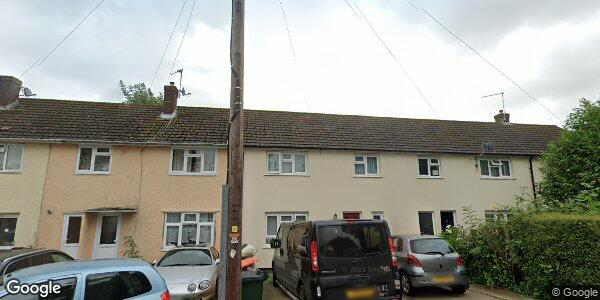

250 10


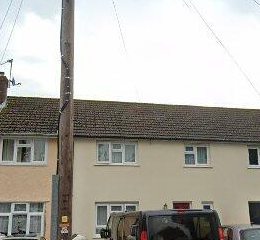

In [71]:
idx =100
idx=200
idx=2200
path  = scd.samples[idx][0]
label = scd.samples[idx][1]

sample = Image.open(path).convert("RGB")
sample.show()

width , height = sample.size

left = 170
top = 250
right = 430
bottom = 10
print(top, bottom )
im1 = sample.crop((left, bottom, right, top))







im1.show()

290 10


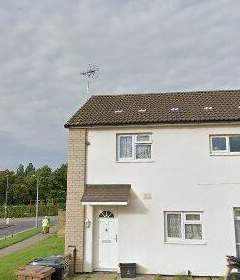

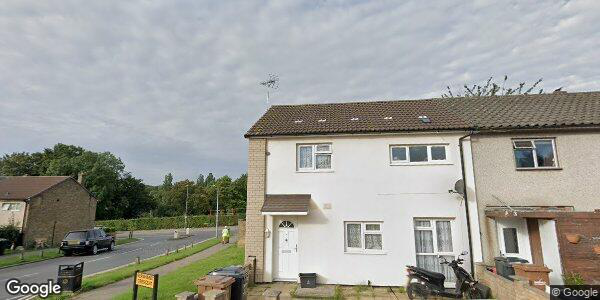

In [44]:
sample